In [7]:
#load necessary packages and data files
Packages <- c("dplyr", "data.table", "ggplot2","stringr","fields", "tidyr",  "lubridate", "RColorBrewer", "igraph", "lubridate")

invisible(suppressPackageStartupMessages(lapply(Packages, library, character.only = TRUE)))

setwd('/local/home/katrinac/parentage/')

#download.file(url = "https://raw.githubusercontent.com/pinskylab/genomics/master/data/known_issues.csv", destfile = "~/parentage/r_data/known_issues.csv")
issues <- read.csv("~/parentage/r_data/known_issues.csv", header=T, stringsAsFactors = F)
#download.file(url = "https://github.com/pinskylab/Clownfish_persistence/blob/master/Data/Data_from_database/fish_db.RData?raw=true", destfile = "~/parentage/r_data/dives_db.RData")
load("~/parentage/r_data/fish_db.RData")
#download.file(url = "https://github.com/pinskylab/Clownfish_persistence/blob/master/Data/Data_from_database/anem_db.RData?raw=true", destfile = "~/parentage/r_data/anem_db.RData")
load("~/parentage/r_data/anem_db.RData")
#download.file(url = "https://github.com/pinskylab/Clownfish_persistence/blob/master/Data/Data_from_database/dives_db.RData?raw=true", destfile = "~/parentage/r_data/dives_db.RData")
load("~/parentage/r_data/dives_db.RData")
#download.file(url = "https://github.com/pinskylab/Clownfish_persistence/blob/master/Data/Data_from_database/fish_db.RData?raw=true", destfile = "~/parentage/r_data/dives_db.RData")
load("~/parentage/r_data/fish_db.RData")
load("~/parentage/r_data/gps_db.RData")
#download.file(url = "https://github.com/pinskylab/Clownfish_persistence/blob/master/Data/anems_tagged.RData", destfile = "~/parentage/r_data/anems_tagged.RData")
load("~/parentage/r_data/anems_tagged.RData")
#download.file(url = "https://github.com/pinskylab/genomics/blob/master/data/fish-obs.RData?raw=true", destfile = "~/parentage/r_data/fish-obs.RData")
fish_obs <- readRDS("~/parentage/r_data/fish-obs.RData") 
#download.file(url = "https://raw.githubusercontent.com/pinskylab/db_backups/master/ligation_1-7-20.csv", destfile = "~/parentage/r_data/ligation_db.csv")
lig_db <- read.csv("~/parentage/r_data/ligation_db.csv", header=T, stringsAsFactors = F)
#download.file(url = "https://raw.githubusercontent.com/pinskylab/db_backups/master/digest_1-7-20.csv", destfile = "~/parentage/r_data/digest_db.csv")
dig_db <- read.csv("~/parentage/r_data/digest_db.csv", header=T, stringsAsFactors = F)
#download.file(url = "https://raw.githubusercontent.com/pinskylab/db_backups/master/extraction_1-7-20.csv", destfile = "~/parentage/r_data/extraction_db.csv")
ext_db <- read.csv("~/parentage/r_data/extraction_db.csv", header=T, stringsAsFactors = F)
offs_input <- read.table(file="~/parentage/colony2/20190523_1340loci/input/all_offspring_corrected.txt", sep= " ", header=TRUE) %>%
    mutate(fish_indiv=as.character(fish_indiv))

"%!in%" <- function(x,table) match(x,table, nomatch = 0) == 0




In [2]:
#load sibling results

#sibs18 <- read.csv(file= "/local/home/katrinac/Sibling-Dispersal/data/1340loci_2018.FullSibDyad.txt", header= TRUE, stringsAsFactors = F) %>%
#    mutate(year="2018")
#do the above line of code for every year of analysis

#allsibs <- bind_rows(sibs12, sibs13, sibs14, sibs15, sibs16, sibs17, sibs18) %>%
#    filter(Probability >= 0.95)

#write.csv(allsibs, file= "/local/home/katrinac/Sibling-Dispersal/data/AllYearsFullSibs.csv", row.names=FALSE)
siblings <- read.csv(file= "/local/home/katrinac/Sibling-Dispersal/data/AllYearsFullSibs.csv", header= TRUE, stringsAsFactors = F)  
nrow(siblings) #should be 124

[1] 124

In [92]:
str(siblings)

'data.frame':	124 obs. of  4 variables:
 $ OffspringID1: chr  "L0340" "L0340" "L0340" "L0341" ...
 $ OffspringID2: chr  "L0341" "L1215" "L2571" "L0373" ...
 $ Probability : num  1 1 0.999 1 1 0.997 0.989 0.998 0.974 0.968 ...
 $ year        : int  2012 2012 2012 2012 2012 2012 2012 2012 2012 2012 ...


In [93]:

#add meta data
#from Allison, just putting all the meta data together (Constants_database_common_functions.R)
##### Match up other relevant info (site, date, fish_indiv, etc.) to fish in the clownfish table
# Pull out year and month into a separate column in dives_db
dives_db_processed <- dives_db %>%
  mutate(year = as.integer(substring(date,1,4))) %>%
  mutate(month = as.integer(substring(date,6,7))) %>%
  mutate(dive_date = date(date))

# Pull all APCL caught or otherwise in the clownfish table
allfish_fish <- fish_db %>%
  select(fish_table_id, anem_table_id, fish_spp, sample_id, anem_table_id, recap, tag_id, color, sex, size, fish_obs_time, fish_notes) %>%
  filter(fish_spp == 'APCL') %>%
  mutate(size = as.numeric(size))  # make the size numeric (rather than chr) so can do means and such

# and their corresponding anemones
allfish_anems <- anem_db %>%
  select(anem_table_id, dive_table_id, anem_obs, anem_id, old_anem_id, anem_notes, anem_obs_time) %>%
  filter(anem_table_id %in% allfish_fish$anem_table_id)

# and the corresponding dive info
allfish_dives <- dives_db_processed %>%
  select(dive_table_id, dive_type, date, year, month, site, gps, dive_notes) %>%
  filter(dive_table_id %in% allfish_anems$dive_table_id) 

# join together
allfish_caught <- left_join(allfish_fish, allfish_anems, by="anem_table_id")
allfish_caught <- left_join(allfish_caught, allfish_dives, by="dive_table_id")

# add in the gen_ids and fish_indiv (now in a separate gen_id table) - gen_id only comes in the time the fish was sequenced, not at all captures
allfish_caught <- left_join(allfish_caught, (fish_obs %>% select(fish_table_id, gen_id, fish_indiv)), by = "fish_table_id")

#get sample ids for ligation ids
ext_db <- ext_db %>%
    select(extraction_id, sample_id)
dig_db <- dig_db %>%
    select(extraction_id, digest_id)
lig_db <- lig_db %>%
    select(ligation_id, digest_id)
ext_dig <- left_join(ext_db, dig_db, by="extraction_id")
dig_lig <- left_join(ext_dig, lig_db, by="digest_id")
lig_samp <- dig_lig %>%
    select(ligation_id, sample_id) %>%
    filter(sample_id %in% allfish_caught$sample_id) #remove everything but sampled APCL

fish_meta <- left_join(allfish_caught, lig_samp,  by="sample_id") %>%
    select(fish_indiv, size, color, sex, gen_id, ligation_id, sample_id, site, date, anem_obs_time, gps) %>%
    filter(!is.na(fish_indiv)) %>%
    distinct(ligation_id, .keep_all = T) %>%
    mutate(ligation_year=year(date)) %>%
    distinct(fish_indiv, .keep_all = T)

#write out fish meta data for Connor



In [94]:
#get specific metadata for offspring
sib_samp1 <- fish_meta %>%
    filter(ligation_id %in% siblings$OffspringID1) 
colnames(sib_samp1) <- paste("sib1", colnames(sib_samp1), sep = "_")

#get specific metadata for parents
sib_samp2 <- fish_meta %>%
    filter(ligation_id %in% siblings$OffspringID2) 
colnames(sib_samp2) <- paste("sib2", colnames(sib_samp2), sep = "_")

#join back into parentage match format
meta_with_sib1 <- left_join(sib_samp1, siblings, by=c(sib1_ligation_id="OffspringID1"))
    

full_sibs <- left_join(meta_with_sib1, sib_samp2,   by=c(OffspringID2="sib2_ligation_id")) 

#the long haul of adding lat lons
results_meta <- full_sibs %>%
    mutate(sib1_time_date =as.character(str_c(sib1_date, sib1_anem_obs_time, sep = " "))) %>%
    mutate(sib1_time_date = ymd_hms(sib1_time_date))%>%
    mutate(sib1_time_date = force_tz(sib1_time_date, tzone = "Asia/Manila")) %>%
    mutate(sib1_time_date = with_tz(sib1_time_date, tzone = "UTC")) %>%
    mutate(sib1_year = year(sib1_time_date)) %>%
    mutate(sib1_month = month(sib1_time_date)) %>%
    mutate(sib1_day = day(sib1_time_date)) %>%
    mutate(sib1_hour = hour(sib1_time_date)) %>%
    mutate(sib1_minute = minute(sib1_time_date)) %>%
    mutate(sib2_time_date =as.character(str_c(sib2_date, sib2_anem_obs_time, sep = " "))) %>%
    mutate(sib2_time_date = ymd_hms(sib2_time_date))%>%
    mutate(sib2_time_date = force_tz(sib2_time_date, tzone = "Asia/Manila")) %>%
    mutate(sib2_time_date = with_tz(sib2_time_date, tzone = "UTC")) %>%
    mutate(sib2_year = year(sib2_time_date)) %>%
    mutate(sib2_month = month(sib2_time_date)) %>%
    mutate(sib2_day = day(sib2_time_date)) %>%
    mutate(sib2_hour = hour(sib2_time_date)) %>%
    mutate(sib2_minute = minute(sib2_time_date))

gps <- gps_db %>%
    mutate(lat=as.numeric(lat)) %>%
    mutate(lon=as.numeric(lon)) %>%
    mutate(time_date = ymd_hms(time)) %>%
    mutate(year = year(time_date)) %>%
    mutate(month = month(time_date)) %>%
    mutate(day = day(time_date)) %>%
    mutate(hour = hour(time_date)) %>%
    mutate(minute = minute(time_date)) %>%
    select(-time_date, -elev, -time) %>%
    group_by(unit, year, month, day, hour, minute) %>%
    mutate(lat =mean(lat)) %>% #create within minute averages
    mutate(lon=mean(lon)) %>%
    distinct(.keep_all = T)

add_sib1_loc <- left_join(results_meta, gps, by=c(sib1_gps="unit",sib1_year="year", sib1_month="month", sib1_day="day", sib1_hour="hour", sib1_minute="minute")) %>%
    rename(sib1_lat="lat", sib1_lon="lon") 

sib_dist <- left_join(add_sib1_loc, gps, by=c(sib2_gps="unit",sib2_year="year", sib2_month="month", sib2_day="day", sib2_hour="hour", sib2_minute="minute")) %>%
    rename(sib2_lat="lat", sib2_lon="lon") 

In [95]:

#calculate the distance 
alldists <- rdist.earth(as.matrix(sib_dist[,c('sib1_lon', 'sib1_lat')]), as.matrix(sib_dist[,c('sib2_lon', 'sib2_lat')]), miles=FALSE, R=6371)
sib_dist$dist_km <- diag(alldists)



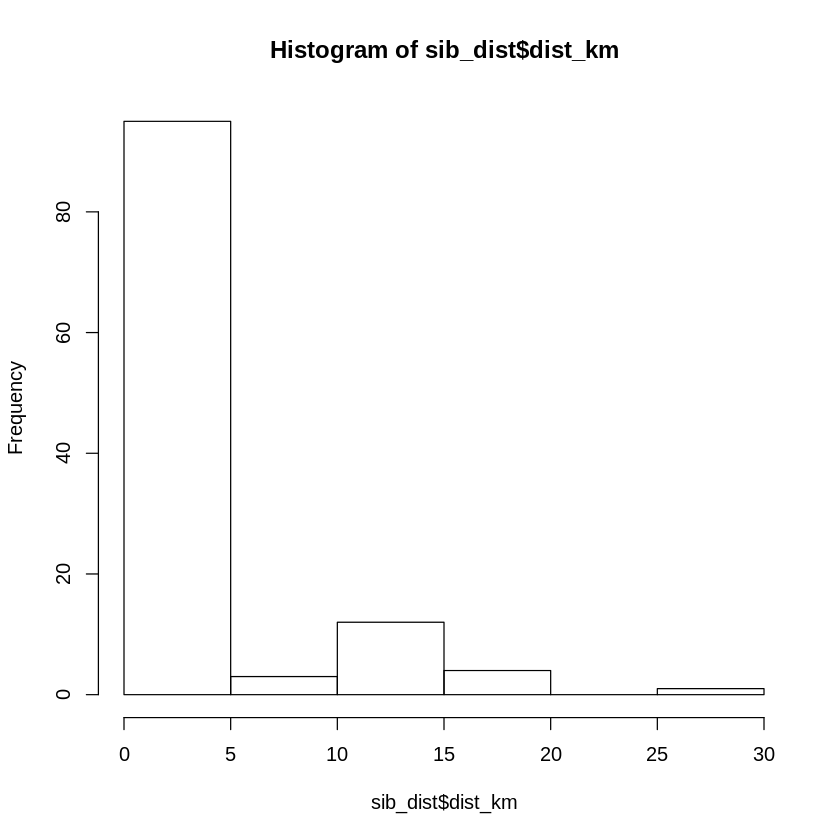

In [96]:
hist(sib_dist$dist_km) #looks like the dispersal results

In [99]:
head(sib_dist)
saveRDS(sib_dist, file="~/Sibling-Dispersal/data/sib_dist.rds")

sib1_fish_indiv,sib1_size,sib1_color,sib1_sex,sib1_gen_id,sib1_ligation_id,sib1_sample_id,sib1_site,sib1_date,sib1_anem_obs_time,...,sib2_year,sib2_month,sib2_day,sib2_hour,sib2_minute,sib1_lat,sib1_lon,sib2_lat,sib2_lon,dist_km
16,4.1,YR,J,16,L0705,APCL14_074,Palanas,2014-06-13,10:40:00,...,2014,6,23,7,31,10.87302,124.7122,10.87143,124.7142,0.2844833
92,5.4,NA,NA,92,L2212,APCL12_094,Palanas,2012-05-09,12:46:00,...,2012,5,11,4,7,10.87356,124.7120,10.76404,124.7852,14.5666040
92,5.4,NA,NA,92,L2212,APCL12_094,Palanas,2012-05-09,12:46:00,...,2012,5,10,1,7,10.87356,124.7120,10.85495,124.7275,2.6759194
101,3.0,NA,NA,101,L2472,APCL12_068,Palanas,2012-05-09,10:13:00,...,2012,5,10,3,58,10.87375,124.7113,10.85778,124.7246,2.2930924
101,3.0,NA,NA,101,L2472,APCL12_068,Palanas,2012-05-09,10:13:00,...,2012,5,10,2,4,10.87375,124.7113,10.85651,124.7257,2.4838212
102,4.0,W,J,102,L2483,APCL12_173,S. Magbangon,2012-05-10,14:25:00,...,2012,5,10,3,23,10.85841,124.7238,10.85746,124.7247,0.1429765


In [108]:
#add lat/lons and distances between all individuals, save for Connor

results_meta <- fish_meta %>%
    mutate(time_date =as.character(str_c(date, anem_obs_time, sep = " "))) %>%
    mutate(time_date = ymd_hms(time_date))%>%
    mutate(time_date = force_tz(time_date, tzone = "Asia/Manila")) %>%
    mutate(time_date = with_tz(time_date, tzone = "UTC")) %>%
    mutate(year = year(time_date)) %>%
    mutate(month = month(time_date)) %>%
    mutate(day = day(time_date)) %>%
    mutate(hour = hour(time_date)) %>%
    mutate(minute=minute(time_date))

fish_meta <- left_join(results_meta, gps, by=c(gps="unit","year", "month", "day", "hour", "minute")) 

saveRDS(fish_meta, file="~/Sibling-Dispersal/data/fish_meta.rds")

In [118]:
#check Connor's work
fish_dist <- readRDS("~/Sibling-Dispersal/data//fish_pairs_df1.rds")

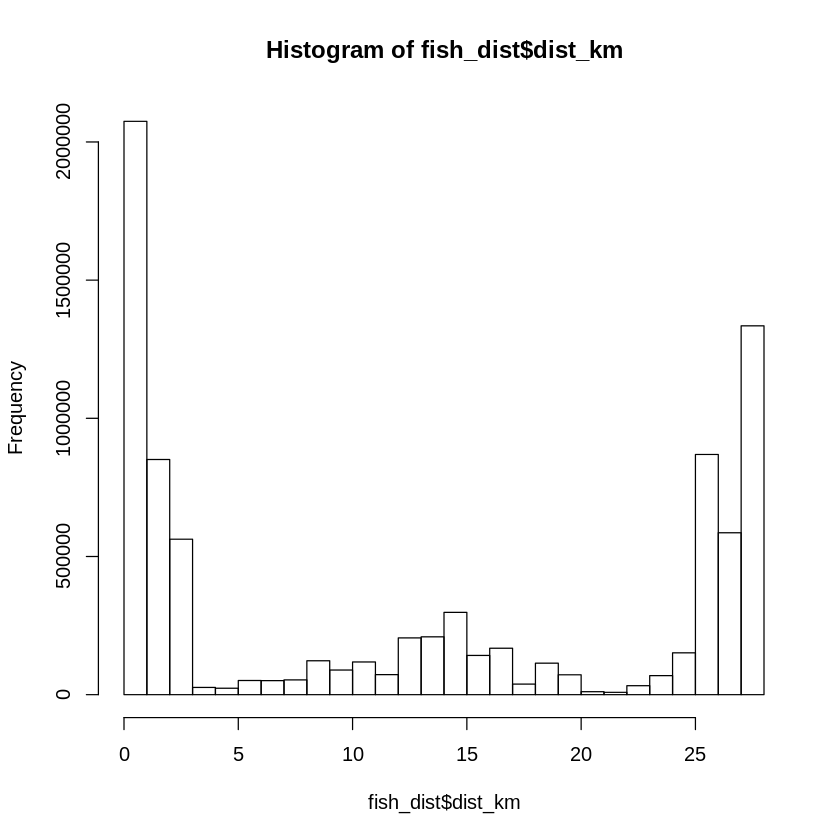

In [121]:
hist(fish_dist$dist_km)

In [107]:
head(fish_meta)

fish_indiv,size,color,sex,gen_id,ligation_id,sample_id,site,date,anem_obs_time,gps,ligation_year
985153000371280,8.5,O,M,NA,L5110,APCL16_366,N. Magbangon,2016-05-30,10:36:00,3,2016
985153000404319,9.7,O,M,NA,L2342,APCL15_404319,Sitio Baybayon,2015-06-11,15:23:00,3,2015
985153000405702,8.3,O,M,NA,L5413,APCL16_735,Sitio Baybayon,2016-06-07,14:12:00,4,2016
2228,12.3,YP,F,NA,L5426,APCL16_748,Tamakin Dacot,2016-06-09,09:32:00,4,2016
2460,9.0,O,M,NA,NA,NA,Palanas,2016-06-14,09:13:00,4,2016
986112100164868,9.0,O,M,NA,L5460,APCL16_784,Palanas,2016-06-14,12:46:00,4,2016


fish_indiv,lat,lon
985153000371280,10.86187,124.7212
985153000404319,10.63264,124.7767
985153000405702,10.63290,124.7769
2228,10.65383,124.7839
2460,10.87444,124.7106
986112100164868,10.87371,124.7112


fish_indiv,lat,lon,fish_indiv_1,fish_indiv1_lat,fish_indiv1_lon
985153000371280,10.86187,124.7212,985153000371280,10.86187,124.7212
985153000404319,10.63264,124.7767,985153000404319,10.63264,124.7767
985153000405702,10.63290,124.7769,985153000405702,10.63290,124.7769
2228,10.65383,124.7839,2228,10.65383,124.7839
2460,10.87444,124.7106,2460,10.87444,124.7106
986112100164868,10.87371,124.7112,986112100164868,10.87371,124.7112


fish_indiv_2,fish_indiv2_lat,fish_indiv2_lon,fish_indiv_1,fish_indiv1_lat,fish_indiv1_lon
985153000371280,10.86187,124.7212,985153000371280,10.86187,124.7212
985153000404319,10.63264,124.7767,985153000404319,10.63264,124.7767
985153000405702,10.63290,124.7769,985153000405702,10.63290,124.7769
2228,10.65383,124.7839,2228,10.65383,124.7839
2460,10.87444,124.7106,2460,10.87444,124.7106
986112100164868,10.87371,124.7112,986112100164868,10.87371,124.7112


fish_indiv_1,fish_indiv_2,fish_indiv1_lat,fish_indiv1_lon,fish_indiv2_lat,fish_indiv2_lon
985153000371280,985153000371280,10.86187,124.7212,10.86187,124.7212
985153000404319,985153000404319,10.63264,124.7767,10.63264,124.7767
985153000405702,985153000405702,10.63290,124.7769,10.63290,124.7769
2228,2228,10.65383,124.7839,10.65383,124.7839
2460,2460,10.87444,124.7106,10.87444,124.7106
986112100164868,986112100164868,10.87371,124.7112,10.87371,124.7112


fish_indiv_1,fish_indiv_2,fish_indiv1_lat,fish_indiv1_lon,fish_indiv2_lat,fish_indiv2_lon
985153000371280,985153000371280,10.86187,124.7212,10.86187,124.7212
985153000404319,985153000404319,10.63264,124.7767,10.63264,124.7767
985153000405702,985153000405702,10.63290,124.7769,10.63290,124.7769
2228,2228,10.65383,124.7839,10.65383,124.7839
2460,2460,10.87444,124.7106,10.87444,124.7106
986112100164868,986112100164868,10.87371,124.7112,10.87371,124.7112


9.493530e-05,26.20060437,26.17819209,24.126330,1.8156603,1.7152981,26.18936317,26.19745236,0.9789129,1.62317083,...,1.3342186,13.69009,13.90904,1.3198239,1.3198239,1.3198239,1.3198239,1.3198239,26.0696980,1.3228576
2.620060e+01,0.00000000,0.03759006,2.484134,27.8399280,27.7465375,0.01400352,0.02301941,27.1244201,27.65667756,...,27.4292510,13.78078,13.44041,27.4218090,27.4218090,27.4218090,27.4218090,27.4218090,0.1324203,27.4299530
2.617819e+01,0.03759006,0.00000000,2.449201,27.8183964,27.7249648,0.02451721,0.02062676,27.1023756,27.63507672,...,27.4074279,13.75036,13.41018,27.3999636,27.3999636,27.3999636,27.3999636,27.3999636,0.1089674,27.4080938
2.412633e+01,2.48413424,2.44920072,0.000000,25.8052462,25.7100119,2.47017903,2.46947742,25.0662373,25.61892589,...,25.3811858,11.39178,11.05820,25.3726922,25.3726922,25.3726922,25.3726922,25.3726922,2.3630052,25.3801637
1.815660e+00,27.83992797,27.81839643,25.805246,0.0000000,0.1005073,27.82893274,27.83743566,0.8508577,0.19362510,...,0.4873830,15.48708,15.70063,0.5046218,0.5046218,0.5046218,0.5046218,0.5046218,27.7096543,0.5051290
1.715298e+00,27.74653750,27.72496483,25.710012,0.1005073,0.0000000,27.73553069,27.74401463,0.7523046,0.09338068,...,0.3890542,15.38692,15.60064,0.4068944,0.4068944,0.4068944,0.4068944,0.4068944,27.6162322,0.4082211


fish_indiv_1,fish_indiv_2,fish_indiv1_lat,fish_indiv1_lon,fish_indiv2_lat,fish_indiv2_lon,fish_km_between_fish1_fish2
985153000371280,985153000371280,10.86187,124.7212,10.86187,124.7212,9.49353e-05
985153000404319,985153000404319,10.63264,124.7767,10.63264,124.7767,0.00000e+00
985153000405702,985153000405702,10.63290,124.7769,10.63290,124.7769,0.00000e+00
2228,2228,10.65383,124.7839,10.65383,124.7839,0.00000e+00
2460,2460,10.87444,124.7106,10.87444,124.7106,0.00000e+00
986112100164868,986112100164868,10.87371,124.7112,10.87371,124.7112,0.00000e+00


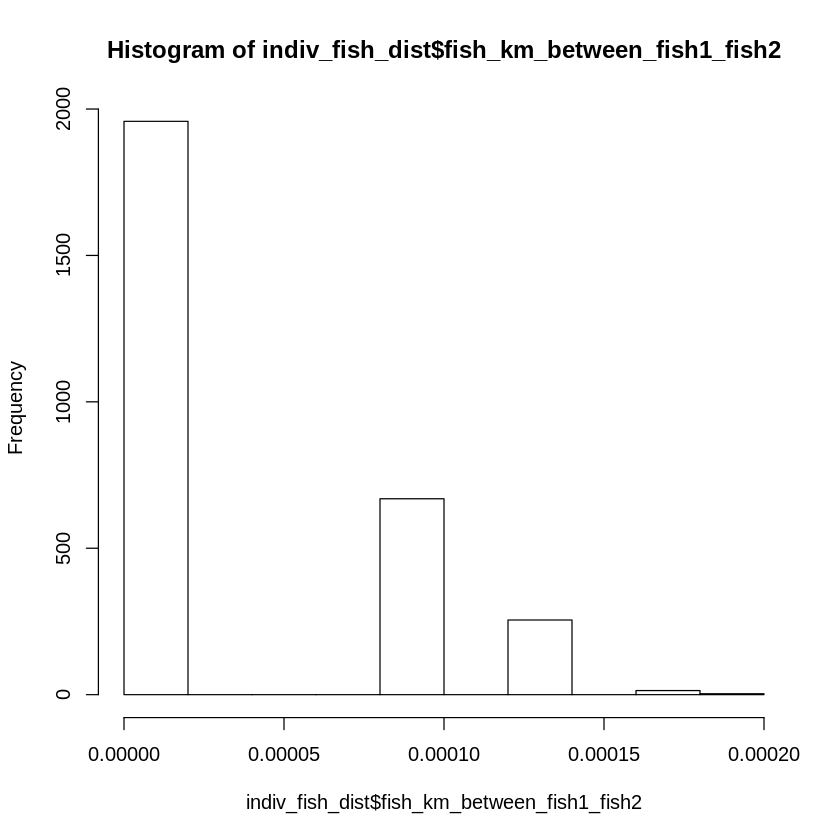

In [109]:
trimmed_fish_meta <- fish_meta %>%
select(fish_indiv, lat, lon)
head(trimmed_fish_meta)

indiv_fish_dist <- trimmed_fish_meta %>%
mutate(fish_indiv_1=fish_indiv) %>%
mutate(fish_indiv1_lat=lat) %>%
mutate(fish_indiv1_lon=lon)
head(indiv_fish_dist)

indiv_fish_dist <- indiv_fish_dist %>%
rename(fish_indiv_2 = fish_indiv) %>%
rename(fish_indiv2_lat = lat) %>%
rename(fish_indiv2_lon = lon)
head(indiv_fish_dist)

indiv_fish_dist_reordered <- indiv_fish_dist[c(4,1,5,6,2,3)]
head(indiv_fish_dist_reordered)

indiv_fish_dist <- indiv_fish_dist_reordered
head(indiv_fish_dist)

#calculate the distance 
alldists <- rdist.earth(as.matrix(indiv_fish_dist[,c('fish_indiv1_lon', 'fish_indiv1_lat')]), as.matrix(indiv_fish_dist[,c('fish_indiv2_lon', 'fish_indiv2_lat')]), miles=FALSE, R=6371)
head(alldists)

indiv_fish_dist$fish_km_between_fish1_fish2 <- diag(alldists)
head(indiv_fish_dist)

hist(indiv_fish_dist$fish_km_between_fish1_fish2)

In [117]:
nrow(fish_meta)
2903*2903-2903


[1] 2903

[1] 8424506

In [111]:
indiv_fish_dist_reordered <- indiv_fish_dist[c(4,1,5,6,2,3)]


In [112]:
head(indiv_fish_dist_reordered)

fish_indiv1_lon,fish_indiv_1,fish_indiv2_lat,fish_indiv2_lon,fish_indiv_2,fish_indiv1_lat
124.7212,985153000371280,10.86187,124.7212,985153000371280,10.86187
124.7767,985153000404319,10.63264,124.7767,985153000404319,10.63264
124.7769,985153000405702,10.63290,124.7769,985153000405702,10.63290
124.7839,2228,10.65383,124.7839,2228,10.65383
124.7106,2460,10.87444,124.7106,2460,10.87444
124.7112,986112100164868,10.87371,124.7112,986112100164868,10.87371


In [91]:
#For loop for Connor
pair_df <- readRDS("~/Sibling-Dispersal/data/filtered_fish_dist.rds") %>%
    distinct(fish1_id, fish2_id, .keep_all = T) %>%
    sample_n(1000) %>%
    mutate(row_number=row_number())

##pair_dt <- as.data.table(pair_df)
##make a list of fish id pairs
pb <- txtProgressBar(min = 0, max =1000, style = 3)

drops_pair_df <- as.data.frame(matrix(nrow=0, ncol=4))
col <- c("fish1_id", "fish2_id", "dist_km", "row_number")
names(drops_pair_df) <- col

for(k in 1:nrow(pair_df)){
    
    pair_eval <- pair_df[k, 1:2]
    
    fish1 <- pair_eval[,1]
    fish2 <- pair_eval[,2]  
    drop_pair <- pair_df %>% 
                filter(fish1_id==fish2 & fish2_id==fish1)
        
drops_pair_df <- bind_rows(drops_pair_df, drop_pair)
    
    
setTxtProgressBar(pb, k)


}
nrow(pair_df)
nrow(drops_pair_df)


  |======================================================================| 100%

[1] 1000

[1] 0

In [96]:
write.csv(pair_df, "~/Sibling-Dispersal/data/PairsWithNoRep.csv", row.names=F)

In [83]:
str(pair_df)
str(drop_pair)
str(drops_pair_df)

'data.frame':	1000 obs. of  4 variables:
 $ fish1_id   : chr  "881" "773" "1974" "1650" ...
 $ fish2_id   : chr  "982126052951240" "2578" "986112100163881" "1723" ...
 $ distance_km: num  6.38 1.98 14.94 0.96 10.39 ...
 $ row_number : int  1 2 3 4 5 6 7 8 9 10 ...
'data.frame':	0 obs. of  4 variables:
 $ fish1_id   : chr 
 $ fish2_id   : chr 
 $ distance_km: num 
 $ row_number : int 
'data.frame':	0 obs. of  5 variables:
 $ fish1_id   : chr 
 $ fish2_id   : chr 
 $ dist_km    : logi 
 $ row_number : int 
 $ distance_km: num 


In [78]:
filtered_pair_df <- as.data.frame(matrix(nrow=0, ncol=4))
col <- c("fish1_id", "fish2_id", "dist_km", "row_number")
names(filtered_pair_df) <- col
filtered_pair_df

fish1_id,fish2_id,dist_km,row_number


In [45]:
as.numeric(pair_eval[,1])
as.numeric(pair_eval[,2])

[1] 9.85153e+14

[1] 9.85153e+14

In [37]:
#pair_df <- readRDS("~/Sibling-Dispersal/data/filtered_fish_dist.rds") %>%
#    distinct(fish1_id, fish2_id, .keep_all = T) %>%
#    mutate(row=row_number())
pair_dt <- as.data.table(pair_df)
nrow(pair_dt)
i=1
pair_dt[i, 1:2]
fish1 <- as.numeric(pair_eval[,1])
fish2 <- as.numeric(pair_eval[,2])

row_to_drop <- as.numeric(pair_dt[fish1_id==fish2 & pair_df$fish2_id==fish1, which = T])

nrow(pair_dt[row != row_to_drop])


[1] 8424506

fish1_id,fish2_id
985153000404319,985153000371280


[1] 8424505

In [34]:
pair_df <- readRDS("~/Sibling-Dispersal/data/filtered_fish_dist.rds") %>%
    distinct(fish1_id, fish2_id, .keep_all = T) %>%
    mutate(row=row_number())

In [35]:
str(pair_df)

'data.frame':	8424506 obs. of  4 variables:
 $ fish1_id   : chr  "985153000404319" "985153000405702" "2228" "2460" ...
 $ fish2_id   : chr  "985153000371280" "985153000371280" "985153000371280" "985153000371280" ...
 $ distance_km: num  26.2 26.18 24.13 1.82 1.72 ...
 $ row        : int  1 2 3 4 5 6 7 8 9 10 ...


In [12]:
row_number <- which(pair_df$fish1_id==fish2 & pair_df$fish2_id==fish1, arr.ind = T)

[1] 2188180

In [15]:
    row_to_drop <- which(pair_df$fish1_id==fish2 & pair_df$fish2_id==fish1, arr.ind = T)


In [18]:
nrow(pair_df %>%
        filter(row_number()!=row_to_drop))
nrow(pair_df)

[1] 8424505

[1] 8424506

In [ ]:
nrow